# **Cohort Analysis With Python**

In this article, I am going to talk about Cohort Analysis and how to analyze it with Python. It widely used for mobile applications/games.
Let's say we created a mobile game and published it. How do we know the game will be popular or die. It depends on the relationship with the users. 
If the entrepreneurs analyze relations with the users, fix bugs and errors and take the necessary steps to organize their relations, they will at least increase their chance of survival.

But, how to understand these relations?

The answer is Cohort Analysis.

## **What is Cohort Analysis?**

Literally, a cohort is a group who shared similar behaviours within a specified period. A group of people born in Turkey in 2022 is an example for cohort related to the number of births in a country. In terms of bussiness problems, cohort represents a group of customers or users. And a cohort analysis is when you try to derive insights from the behaviour of this group. Cohorts analysis make it easy to analyze the user behaviour and trends without having to look at the behaviour of each user individually.

## **Why Cohort Analysis?**
The most valuable feature of cohort analysis is that it helps companies answer some of the targeted questions by examining the relevant data. Cohort Analysis helps to understand how the behaviour of users can affect the business in terms of acquisition and retention and to analyze the customer churn rate.

## **Cohort Analysis Using Python**
We will use the Online Retail dataset. You can find it [here](https://archive.ics.uci.edu/ml/datasets/Online+Retail) or [here](https://www.kaggle.com/mathchi/online-retail-ii-data-set-from-ml-repository).



In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

# data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from operator import attrgetter

# machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
# due to some reasons, we need to use encoding parameters
file ='../input/online-retail-ii-data-set-from-ml-repository/Year 2010-2011.csv'
import chardet
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

df = pd.read_csv(file,encoding='ISO-8859-1')

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


I will directly delete the missing values and duplicates as they are not in the scope of our topic.

In [4]:
df.dropna(inplace=True)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.describe()

,Quantity,Price,Customer ID
count,401605.000000,401605.000000,401605.000000
mean,12.183245,3.474100,15281.154341
std,250.282726,69.763952,1714.008869
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


There some negative values in the Quantity and Price features. It can't be possible. So I will filter the data greater than zero.

In [7]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

## **Data Preparation**
For cohort analysis, we need three labels. These are payment period, cohort group and cohort period/index.

To work with the time series, we need to convert the type of related feature. The format shuld be as in the dataset.

In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

Now, we need to create the cohort and order_month variables. The first one indicates the monthly cohort based on the first purchase date and the second one is the truncated month of the purchase date.

In [9]:
df['order_month'] = df['InvoiceDate'].dt.to_period('M')

In [10]:
df['cohort'] = df.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

Then, we aggregate the data per cohort and order_month and count the number of unique customers in each group.

In [11]:
df_cohort = df.groupby(['cohort', 'order_month']).agg(n_customers=('Customer ID', 'nunique')).reset_index(drop=False)

In [12]:
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

Then, we aggregate the data per cohort and order_month and count the number of unique customers in each group.

In [13]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number', values='n_customers')

To obtain the retention matrix, we need to divide the values each row by the row's first value, which is actually the cohort size — all customers who made their first purchase in the given month.

In [14]:
cohort_size = cohort_pivot.iloc[:, 0]

In [15]:
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

Lastly, we plot the retention matrix as a heatmap. Additionally, we wanted to include extra information regarding the cohort size. That is why we in fact created two heatmaps, where the one indicating the cohort size is using a white only colormap — no coloring at all.

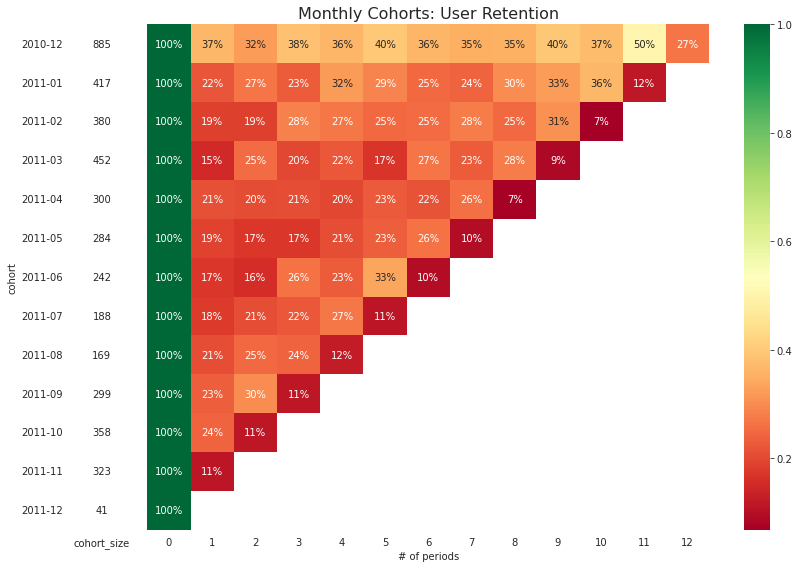

In [16]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In the image, we can see that there is a sharp drop-off in the second month (indexed as 1) already, on average around 80% of customers do not make any purchase in the second month. The first cohort (2010–12) seems to be an exception and performs surprisingly well as compared to the other ones. A year after the first purchase, there is a 50% retention. This might be a cohort of dedicated customers, who first joined the platform based on some already-existing connections with the retailer. However, from data alone, that is very hard to accurately explain.

Throughout the matrix, we can see fluctuations in retention over time. This might be caused by the characteristics of the business, where clients do periodic purchases, followed by periods of inactivity.